(c) Arsh Singh, Dec 2022

This file is associated with my research project regarding the prescriptive power of non-physician and  opioid prescriptions. This shows (almost) all the works from raw data to final data, data analysis, and figures. I do not show the works for census data formatting

### What am I doing?
In the USA, many states started allowing non-physicians such as Nurse Practitioners and Physician's Assistants to prescribe opioids. In this project, I start with the prior that allowing non-physicians to prescribe schedule II drugs combined with increased freedom for practice such as not requiring physicians oversight, will lead to an increase in prescription opioids. (I see exactly the opposite of that in the data, at least in the beginning. More later.)

### How am I doing it?
Regression Discontinuity. I employ the variation in the timing of various states passing laws that increase the practicing and prescription powers of non-physicians, for a statistical technique used to estimate causal effects, called regression discontinuity.

### Why should anyone care about what I am doing?
Regression discontinuities are rare. They can be inferred to be causal.

In this project I estimate/measure exactly how much the changing of law contributed to the increase in prescription of opioids.

Passing of Law ---> increased opioids

This is called the first stage. Once I have the causal first stage I can use it to estimate the causal effects of opioids to health.

Increased opioids ---> health effects

One can ask the question, why do we need to worry about causality? We know how many pills were prescribed and where they went. The answer is that studying the effects of pills in demographics is not so easy. We do not know if all the pills were taken by the persons who they were prescribed to. If they were taken by anyone. Since the pills are expensive, limited by prescription, and are very addictive, there may be secondary effects such as may come from taking street opioids such as fentanyls.

Having a dependable causal first-stage can let us extract the causal effect of marginal effect of increase in pill to overall health effects.

### DATA SOURCES

#### Opioids Data: Washington Post ARCOS dataset
I use the raw arcos dataset cleaned and hosted by washington post. 

URL: https://wpinvestigative.github.io/arcos/#download-the-raw-data

This data follows each painkiller pill in the years 2006-2012 across all states in the USA. As expected, it is a massive dataset of 17GB (or 17 million kB). 

I could use the arcos API provided by wapo to perform some tasks such as collapsing the data to desired levels, but in my experience their server was always too busy to even perform simple tasks. So I am using pyspark to be able to manipulate the BigData using my limited RAM.

#### Population Data: US Census
State and country level intercestal annual population estimates from US Census.

URL: https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/state/st-est00int-alldata.csv

#### Prescriptive Power of Non-Physicians
Gadbois, Emily A., et al. "Trends in state regulation of nurse practitioners and physician assistants, 2001 to 2010." Medical Care Research and Review 72.2 (2015): 200-219. Accessed on 12-24-2022.

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [2]:
folder='D:/arcos_all_washpost/'

In [7]:
scdf1=my_data.groupBy('ID').agg(sum('QTY').alias('both'))
scdf2=my_data.filter(col('DRUG_NAME') == 'HYDROCODONE').groupBy('ID').agg(sum('QTY').alias("hydrocodone"))
scdf3=my_data.filter(col('DRUG_NAME') == 'OXYCODONE').groupBy('ID').agg(sum('QTY').alias("oxycodone"))
scdf12=scdf1.join(scdf2,scdf1.ID == scdf2.ID,"inner").drop(scdf2.ID)
scdf123=scdf12.join(scdf3,scdf12.ID == scdf3.ID,"inner").drop(scdf3.ID)
scdf123_1=scdf123.withColumn('STATE',substring(scdf123.ID,1,2))
df=scdf123_1.toPandas()

In [8]:
main=df.copy()

In [9]:
# create months, years
main['months']=main['ID'].str.slice(start=2,stop=None,step=1).astype(int)
main['year']=main['months'].div(12).astype(int)

In [10]:
# filter out 2012, keep 2006-2011
main1=main[main['year']<2012]
main1 = main1.iloc[:,[1,4,5,6,2,3,0]]
main1.head()

,ID,STATE,months,year,hydrocodone,oxycodone,both
0,AZ24115,AZ,24115,2009,27877975.0,2.534856e+07,5.322653e+07
1,CT24074,CT,24074,2006,4063300.0,1.060125e+07,1.466455e+07
2,CT24108,CT,24108,2009,6483600.0,1.475485e+07,2.123845e+07
4,MI24079,MI,24079,2006,18638500.0,1.019536e+07,2.883386e+07
5,MN24086,MN,24086,2007,2919895.0,3.604983e+06,6.524878e+06


I took data from census and changed it to match the format of the current dataframe in another notebook: UsStatesPop2006to12.ipynb

In [11]:
file='pop.csv'
path=folder+file
pop=pd.read_csv(path)

In [12]:
main2=pd.merge(main1,pop,on=['STATE','year'])
main_std=main2.copy()

I will use the state population to standardize the opioid amounts

In [13]:
# Creating standardized variables by dividing the quantity of drug by state population
for v in ['hydrocodone','oxycodone','both']:
    var=v+'_per_cap'
    main_std[var]=main2[v].astype(int)/main2['pop'].astype(int)
main_std
panel=main_std.copy(0)

I took data about the time of passage of law of allowing NP and PA to prescribe Sch II drugs and made it into dictionaries
    

In [14]:
file='treatment.csv'
path=folder+file
treatment=pd.read_csv(path)

In [15]:
main_std_tr=pd.merge(main_std,treatment, on=['STATE','year'])
main_std_tr.head()

,ID,STATE,months,year,hydrocodone,oxycodone,both,pop,hydrocodone_per_cap,oxycodone_per_cap,both_per_cap,np,np_no_md,pa,any
0,AZ24115,AZ,24115,2009,27877975.0,2.534856e+07,5.322653e+07,6343154,4.394971,3.996207,8.391178,1,1,1,1
1,AZ24110,AZ,24110,2009,24619375.0,2.153884e+07,4.615822e+07,6343154,3.881251,3.395604,7.276855,1,1,1,1
2,AZ24118,AZ,24118,2009,26808600.0,2.697941e+07,5.378801e+07,6343154,4.226383,4.253311,8.479694,1,1,1,1
3,AZ24117,AZ,24117,2009,26459075.0,2.562547e+07,5.208455e+07,6343154,4.171281,4.039863,8.211144,1,1,1,1
4,AZ24116,AZ,24116,2009,25195600.0,2.387104e+07,4.906664e+07,6343154,3.972093,3.763276,7.735369,1,1,1,1


In [16]:
# year of passing of law
np_dict={'STATE':['LA','KY','VA','HI'],'np_year':[2006,2007,2007,2009]}
np_df=pd.DataFrame.from_dict(np_dict)
np_df['np_months']=np_df['np_year']*12+12 
            # +12 assuming law gets enforced beginning of next year
np_df=np_df.drop(columns=['np_year'])
np_df

,STATE,np_months
0,LA,24084
1,KY,24096
2,VA,24096
3,HI,24120


In [17]:
np_no_md_dict={'STATE':['AZ','CO','HI','ID','MI','RI','WA','WY','CA','SC'],
              'year':[2006,2010,2005,2005,2005,2009,2006,2006,2007,2006]}
np_no_md_df=pd.DataFrame.from_dict(np_no_md_dict)
np_no_md_df['np_no_md_months']=np_no_md_df['year']*12+12 
            # +12 assuming law gets enforced beginning of next year
np_no_md_df=np_no_md_df.drop(columns=['year'])
np_no_md_df

,STATE,np_no_md_months
0,AZ,24084
1,CO,24132
2,HI,24072
3,ID,24072
4,MI,24072
5,RI,24120
6,WA,24084
7,WY,24084
8,CA,24096
9,SC,24084


In [18]:
pa_dict={'STATE':['PA','VA','DC','NY','IL'],
         'year':[2007,2007,2007,2008,2010]}
pa_df=pd.DataFrame.from_dict(pa_dict)
pa_df['pa_months']=pa_df['year']*12+12
        # +12 assuming law gets enforced beginning of next year
pa_df=pa_df.drop(columns=['year'])   
pa_df

,STATE,pa_months
0,PA,24096
1,VA,24096
2,DC,24096
3,NY,24108
4,IL,24132


In [19]:
panel1=pd.merge(main_std_tr,np_df,on='STATE',how='left')
panel2=pd.merge(panel1,np_no_md_df,on='STATE',how='left')
panel3=pd.merge(panel2,pa_df,on='STATE',how='left')
panel3['months_ref_np']=panel3['months']-panel3['np_months']
panel3['months_ref_np_no_md']=panel3['months']-panel3['np_no_md_months']
panel3['months_ref_pa']=panel3['months']-panel3['pa_months']

In [20]:
# Excluding Vermont due to it's unusually low per capita opioid prescription 
panel_temp=panel3[panel3['STATE']!='VA'] 

In [21]:
panel_temp=panel_temp[['STATE','hydrocodone_per_cap','oxycodone_per_cap','both_per_cap','months_ref_np_no_md']].dropna()
panel_np_no_md=panel_temp.groupby('months_ref_np_no_md').mean()
panel_np_no_md['months_ref_np_no_md']=panel_np_no_md.index
panel_np_no_md2=panel_np_no_md[panel_np_no_md['months_ref_np_no_md']<18][panel_np_no_md['months_ref_np_no_md']>-18]
#panel_np_no_md2=panel_np_no_md.copy()

C:\Users\arsha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


### Data Visualization

Text(0, 0.5, 'Opioids pescribed per capita')

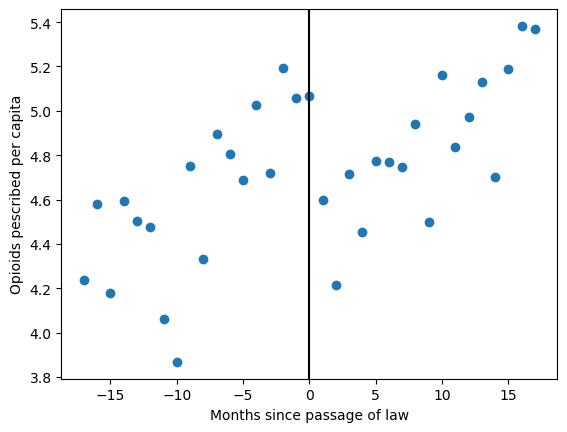

In [22]:
plt.scatter(panel_np_no_md2['months_ref_np_no_md'],panel_np_no_md2['both_per_cap'])
plt.axvline(x = 0, color = 'black')
plt.xlabel('Months since passage of law')
plt.ylabel('Opioids pescribed per capita')

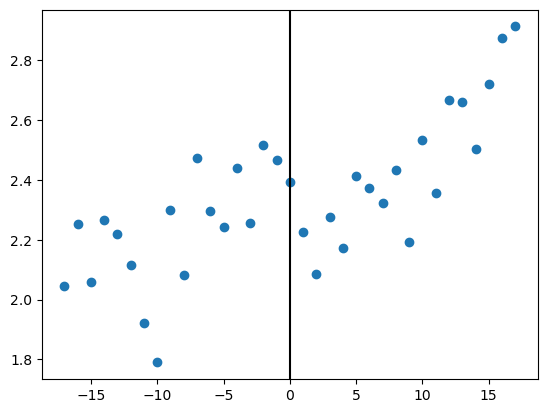

In [23]:
plt.scatter(panel_np_no_md2['months_ref_np_no_md'],panel_np_no_md2['hydrocodone_per_cap'])
plt.axvline(x = 0, color = 'black')

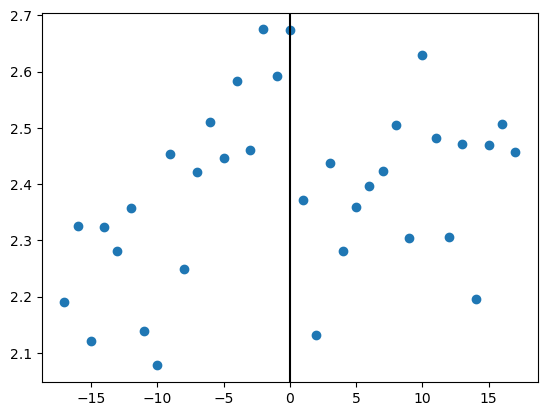

In [24]:
plt.scatter(panel_np_no_md2['months_ref_np_no_md'],panel_np_no_md2['oxycodone_per_cap'])
plt.axvline(x = 0, color = 'black')